<a href="https://colab.research.google.com/github/YannEhouman/Detecter_des_faux_billets/blob/main/Yann_Ehouman_1_Notebook_102022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

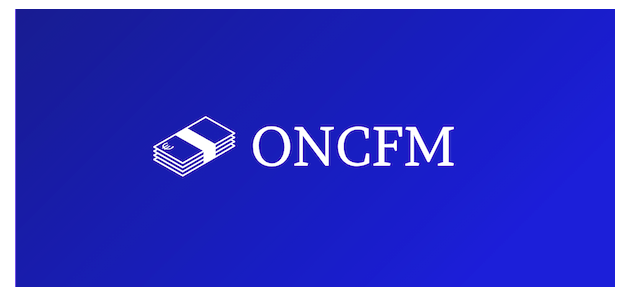

Pour ce projet j'ai pour mission de mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets. Et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent.

# <font color="blue">**I.PREPARATION DES DONNEES**</font>

---



In [ ]:
# importer les bibliotheques
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import csv 
from sklearn.cluster import KMeans

In [ ]:
#Importer les bibliothèques machine learning 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split 
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from scipy.stats import t, shapiro

In [ ]:
#Chargement des données 
data=pd.read_csv('/content/drive/MyDrive/Cours/OPEN CLASSROOM/P10_Ehouman_Yann/billets (1).csv', sep=';')
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [ ]:
#Selection des données chiffrées du dataframe
data2=data.iloc[:,1:]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Mise à l'échelle des données du dataframe
scaler.fit(data2)
data_scaled = scaler.transform(data2)
#Conversion de la liste en datatframe
data_nv = pd.DataFrame(data=data_scaled)
#Ajout de la colonne "is_genuine"
data_nv['is_genuine'] = data['is_genuine']
#Colonnes renommées
data_nv = data_nv[['is_genuine',0,1,2,3,4,5]]
data_nv.columns=['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']
data_nv.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,-0.486540,2.774123,3.163240,0.051286,-1.128325,0.173651
1,True,-1.633729,-2.236535,-0.799668,-1.078937,-0.696799,0.471666
2,True,2.397823,1.504756,-1.291191,-0.129549,-0.912562,0.551901
3,True,-1.961498,-0.399294,0.060498,-1.304982,-0.610494,0.953075
4,True,-0.748754,0.836669,-1.414072,-0.672057,1.417677,-0.158750


In [ ]:
#Nouveau df sans valeur manquante 
data_noNa = data_nv[data_nv['margin_low'].isna()==False]

# Séparation des variables
X = data_noNa.drop('margin_low', axis = 1) 
Y = data_noNa[['margin_low']] 

print('data:', data_nv.shape)
print('data Not NA:', data_noNa.shape)

data: (1500, 7)
data Not NA: (1463, 7)


In [ ]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=data_noNa).fit()                     

x = data_nv.drop(columns = ['is_genuine','margin_low'],axis=1) 
ypred = reg_multi.predict(x)
print(ypred)

# Imputation des valeurs manquantes par les valeurs prédictives:
data_nv["margin_low"]= data_nv["margin_low"].fillna(ypred)

0       0.456172
1      -0.523006
2      -0.542559
3      -0.496374
4       0.137824
          ...   
1495    1.063576
1496    1.463141
1497    0.624351
1498    0.486158
1499    0.532057
Length: 1500, dtype: float64


# <font color="blue">**1.2.Vérifier la colinéarité des variables**

In [ ]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=data_nv).fit()


In [ ]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.012790241853211,
 1.1452953155830747,
 1.2292627049179958,
 1.40351683157986,
 1.5747645461870914]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.
# <font color="blue">**1.3.Testez l’homoscédasticité**
On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [ ]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.530106669837456e-16


La p-valeur ici n'est pas inférieure à  5 %, on ne rejette pas l'hypothèse  H0  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

# <font color="blue">**1.4.Testez la normalité des résidus**
Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [ ]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9848130941390991, pvalue=1.8457929629178693e-11)

Ici, l'hypothèse de normalité est remise en cause (p-value = 1.84 e-11 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.


# <font color="blue"> **1.5.Part de la variable nature du billet**</font>

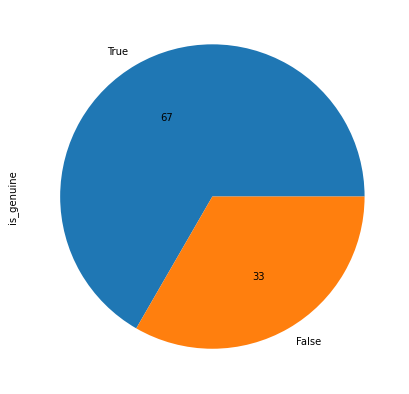

In [ ]:
data_nv['is_genuine'].value_counts().plot(kind='pie', autopct='%.0f', figsize=(7,7))

# <font color="blue">**II.ANALYSE DES DONNEES**</font>

---



In [ ]:
#preparer les données d'entrainement
X=data_nv.iloc[:,1:]
Y=data_nv.iloc[:,0]
print(X.head())
print(Y.head())

   diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.486540     2.774123      3.163240    0.051286  -1.128325  0.173651
1 -1.633729    -2.236535     -0.799668   -1.078937  -0.696799  0.471666
2  2.397823     1.504756     -1.291191   -0.129549  -0.912562  0.551901
3 -1.961498    -0.399294      0.060498   -1.304982  -0.610494  0.953075
4 -0.748754     0.836669     -1.414072   -0.672057   1.417677 -0.158750
0    True
1    True
2    True
3    True
4    True
Name: is_genuine, dtype: bool


In [ ]:
#division de la base de donnée
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)

(1200, 6)
(300, 6)


In [ ]:
#creation du modele
model=LogisticRegression(solver='liblinear', random_state=0)
model.fit(x_train,y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
#test model
predictions=model.predict(x_test)
model.score(x_test,y_test)
#print(predictions)
#print(y_test)

0.99

In [ ]:
#evaluation du modele
print(classification_report(y_test, predictions))
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       110
        True       0.99      0.99      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

0.99


In [ ]:
dimension_billet=[[171.94,104.11,104.16,4.08,3.35,111.76]]
scaled_result = scaler.transform(dimension_billet)
res=model.predict(scaled_result)
if res==1:
    print("Le billet est vrai !")
else:
    print("C'est un faux billet !")

C'est un faux billet !


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


# <font color="blue"> **2.1 Le modèle GLM**

In [ ]:
reg_log = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length', 
                  data=data, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1463
Model:                                                   GLM   Df Residuals:                     1456
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.158
Date:                                       Sat, 22 Oct 2022   Deviance:                       78.315
Time:                                               14:06:36   Pearson chi2:                 2.54e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.


Retirez les variables non significatives On va donc maintenant retirer les variables non significatives. On commence par la moins significative : "diagonal", car elle a une p-valeur de 0.72.

In [ ]:
reg_log = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length', 
                  data=data, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1463
Model:                                                   GLM   Df Residuals:                     1457
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.218
Date:                                       Sat, 22 Oct 2022   Deviance:                       78.437
Time:                                               14:07:39   Pearson chi2:                 2.57e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

In [ ]:
reg_log = smf.glm('is_genuine~height_right+margin_low+margin_up+length', 
                  data=data, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1463
Model:                                                   GLM   Df Residuals:                     1458
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.777
Date:                                       Sat, 22 Oct 2022   Deviance:                       79.555
Time:                                               14:10:01   Pearson chi2:                 3.00e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

In [ ]:
a_prevoir = pd.DataFrame({'height_right': 103.46, 'margin_low': 4.04, 'margin_up': 3.48, 'length': 112.54}, index=[0])
is_genuine_prev = reg_log.predict(a_prevoir)
if round(is_genuine_prev[0], 2)==1:
    print("Le billet est vrai !")
else:
    print("C'est un faux billet !")
    			

C'est un faux billet !


# <font color="blue"> **2.2 Matrix de confusion**

In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
#matrice de confusion 

cm = confusion_matrix(y_test, predictions)

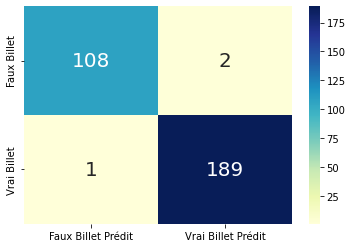

In [ ]:
col =["Faux Billet Prédit","Vrai Billet Prédit"]
row = ["Faux Billet","Vrai Billet"]
fs = 20
sns.heatmap(cm,annot=True, cmap = "YlGnBu",fmt="d",annot_kws={"fontsize":fs}
            ,xticklabels=col,yticklabels=row)

# <font color="blue">**2.3 Algorithme de verification csv**</font>

In [ ]:
#Importation du fichier à analyser
sample_csv = pd.read_csv('/content/drive/MyDrive/Cours/OPEN CLASSROOM/P10_Ehouman_Yann/billets_production.csv')
#Creation d'une variable avec les dimensions à étudier
dimension_billet2=sample_csv[['diagonal','height_left','height_right','margin_low','margin_up','length']]
#Remise en norme des donnée qui ont été mise à échelle pour l'étude
scaled_result = scaler.transform(dimension_billet2)
#création d'une colonne dans le dataframe afin de visualiser les résultats
sample_csv['Resulat']=model.predict(scaled_result)
sample_csv['Resulat']

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


0    False
1    False
2    False
3     True
4     True
Name: Resulat, dtype: bool

# <font color="blue">**III.METHODE K-MEANS**</font>

---



In [ ]:
#cluster k-means 
model1=KMeans(n_clusters=2)
model1.fit(x_train)

KMeans(n_clusters=2)

In [ ]:
clusters = model1.predict(x_test)

In [ ]:
cluster_result = pd.DataFrame()
cluster_result['cluster'] = clusters

In [ ]:
cluster_result.head()

,cluster
0,0
1,0
2,1
3,1
4,1


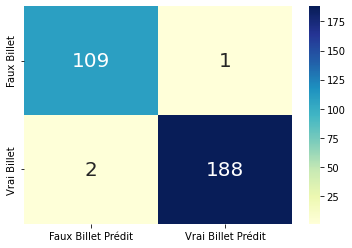

In [ ]:
cm1 = confusion_matrix(y_test, clusters)
sns.heatmap(cm1,annot=True, cmap = "YlGnBu",fmt="d",annot_kws={"fontsize":fs}
            ,xticklabels=col,yticklabels=row)

Avec ses resultats, on peut dire que ses deux modeles de prediction (regression logistique et le K-means) sont assez similaires pour ce cas précis.